# Activity derivatives of NaCl and NaI using the q-potential and other potentials

## Loading modules

In [1]:
%matplotlib inline
from IPython.display import display, Image, Math, Latex
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi
import os

## Loading/computing and plotting the RDFs 

Here, we define a function loading/computing and plotting the radial distribution functions (RDFs) later used to calculate excess coordination numbers. 

In [2]:
def plotRDFs(pot,cutoff_value,moments,cation,anion,rdfAtom,conc,subplot):
    
    """ This function loads and plots RDFs and takes ten arguments:
    - pot: 'PME', 'qpotential', 'SP1', or 'SP3'
    - cutoff_value: 1.28 (nm)
    - moments: 2, 3, 5, 7, or 300
    - cation: 'Na'
    - anion: 'I' or 'Cl'
    - rdfAtom: 'I' or 'Cl
    - conc - 1.0, 2.0, 3.0 (m)
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = '..'

    # Creating array with indices of blocks available (choose depending on length of trajectory or number of block files stored)
    block_range = np.arange(1,19,1)

    cnt = 0 # Initializing index to make trajectory only to be read once
    
    index = 0 # Initializing concentration index                     
    
    if pot is 'qpotential':
        wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/m'+str(moments)+'/'+cation.lower()+anion.lower()+'/'
    
    else:
        wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/'+cation.lower()+anion.lower()+'/'
        
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    
    for block in block_range: # Looping over blocks  

        # if pickle files exist, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
        
        # if simulation output files exist, use those
        elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):
            
            # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
            while (cnt < 1):
                
                import mdtraj as md

                struct = md.load_pdb(wdir_sim_data+'out.pdb')
                N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                
                sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom) # Selecting atoms needed in trajectory
   
                print("Reading in trajectory...")
                traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                nbrFrames = traj.n_frames
                start = nbrFrames/10
                traj_equil = traj[start:nbrFrames]
                print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)
                
                cnt = cnt + 1
            
            startFrac = start / nbrFrames

            endFrac = 1 - startFrac
            first = nbrFrames*startFrac + (block-1)*(nbrFrames*endFrac)/len(block_range)
            last = nbrFrames*startFrac + block*(nbrFrames*endFrac)/len(block_range)

            traj_block = traj[first:last]
            print("Number of frames in trajectory block: ", traj_block.n_frames)

            # Analysis: Calculating RDFs
            r_max = 2.80
            
            pair_cc = traj_block.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
            pair_wc = traj_block.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
            r, g_cc = md.compute_rdf(traj_block, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            r, g_wc = md.compute_rdf(traj_block, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
            g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

            g_cc_avg = g_cc_avg+g_cc/len(block_range)
            g_wc_avg = g_wc_avg+g_wc/len(block_range)

            for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block)], [g_cc, g_wc, r]):

                np.savetxt(file_name, var)
                print("next check...")
            
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
            
    subplot.plot(r,g_cc_avg, label="$g_{cc}(r)$", color='magenta')
    subplot.plot(r,g_wc_avg, label="$g_{wc}(r)$", color='blue')
    subplot.set_xlabel("$r/nm$", fontsize=18)
    subplot.set_ylabel("$g(r)$", fontsize=18)

## Plotting RDFs
Here, we plot the RDFs for the selected forcefield, watermodel and ion pairs.

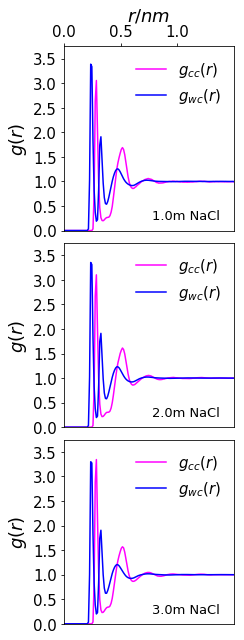

In [3]:
pot = 'qpotential'

cutoff_value = 1.28

moments = 2

cations = ['Na']
anion = 'Cl'
rdfAtom = 'Cl' # Choose which atom in the anion to compute distances from
concs = np.linspace(start=1.0, stop=3.0, num=3)

n_rows = len(concs)
n_cols = len(cations)


fig_dim = np.array((3.5, 9))
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        plotRDFs(pot,cutoff_value,moments,cations[j],anion,rdfAtom,concs[i],ax)
        ax.annotate(str(concs[i])+'m '+cations[j]+anion,xy=(.52,.06), fontsize=13, xycoords='axes fraction')
        
        if j == 0:
            ax.yaxis.tick_left()
            ax.yaxis.set_label_position("left")
        
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            
        elif 0<i<5:
            ax.xaxis.set_visible(False)

        else:
            ax.xaxis.tick_bottom()

        
        plt.xlim((0, 1.5))
        plt.ylim((0, 3.75))
        plt.xticks(np.arange(0,1.5,0.5), fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc=1, fontsize=15,frameon=False)
        plt.tight_layout(w_pad=0.0,h_pad=0.0)
plt.show()

## Compute excess coordination numbers
Here, the method to calculate the excess coordination numbers, $\Delta N_{cc}(r)$ and $\Delta N_{wc}(r)$, is defined. The excess coordination number of salt around salt is defined in terms of the running Kirkwood-Buff integral according to

\begin{align}
\Delta N_{cc}(r) = \rho_{c}G_{cc}(r)
\label{eq:actDer}
\end{align}

The property that is plotted is denoted $\Gamma(r)$, and is defined as

\begin{align}
\Gamma(r) = \Delta N_{cc}(r) - \Delta N_{wc}(r)
\tag{6}
\end{align}

This property is later used to calculate $a_{c}'$.

In [4]:
def plotExcCoordNbrs(pot,cutoff_value,moments,cation,anion,rdfAtom,conc,subplot):
    
    """ This function computes and plots the excess coordination numbers and takes ten arguments:
    - pot: 'PME', 'qpotential', 'SP1', or 'SP3'
    - cutoff_value: 1.28 (nm)
    - moments: 2, 3, 5, 7, or 300
    - cation: 'K' or 'Na'
    - anion: 'I' or 'Cl'
    - rdfAtom: 'I' or 'Cl
    - conc - 1.0, 2.0, 3.0 (m)
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = '..'

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)

    index = 0 # Initializing concentration index                     
        
    if pot is 'qpotential':
        wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/m'+str(moments)+'/'+cation.lower()+anion.lower()+'/'
    
    else:
        wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/'+cation.lower()+anion.lower()+'/'
    
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    V_avg = 0
    rho_c_avg = 0
    rho_w_avg = 0

    for block in block_range: # Looping over blocks  

        # if pickle file exists, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            V = np.loadtxt(wdir_sim_data+'V_'+str(block))
            V_avg = V_avg + V/len(block_range) # Calculating average among blocks
            rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
            rho_c_avg = rho_c_avg + rho_c/len(block_range)
            
        # if simulation output files exist, use those
        elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):
            
            cnt = 0 # Initializing index to make trajectory only to be read once
            
            # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
            while (cnt < 1):
                
                import mdtraj as md
                
                struct = md.load_pdb(wdir_sim_data+'out.pdb')
                N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                
                sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom)
   
                print("Reading in trajectory...")
                traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                nbrFrames = traj.n_frames
                start = nbrFrames/10
                traj_equil = traj[start:nbrFrames]
                print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)
                
                cnt = cnt + 1
            
            startFrac = start / nbrFrames

            end = nbrFrames - start
            first = start + (block-1)*end/len(block_range)
            last = start + block*end/len(block_range)

            traj_block = traj[first:last]
            print("Number of frames in trajectory block: ", traj_block.n_frames)

            # Analysis: Calculating RDFs
            r_max = 2.80
            
            pair_cc = traj_block.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
            pair_wc = traj_block.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
            r, g_cc = md.compute_rdf(traj_block, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            r, g_wc = md.compute_rdf(traj_block, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
            g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Average ion-ion rdf
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Average water-ion rdf
            
            # Computing volume using box vectors
            V = 0
            for vec in traj_block.unitcell_lengths:
                V = V + vec[0]*vec[1]*vec[2] / traj_block.n_frames # Volume for current block

            V_avg = V_avg + V/len(block_range) # Average volume (nm³)
            
            # Computing number density of ions
            rho_c = N_c / V # Average number density of ions (nm⁻³)
            rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of ions (nm⁻³)
            
            for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)], [g_cc, g_wc, r, V, rho_c]):

                if file_name in (wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)):
                    f = open( file_name, 'w' )
                    f.write( repr(var) + '\n' )
                    f.close()
                    print("pickle", file_name, "created")
                else: 
                    np.savetxt(file_name, var)
                    print("pickle", file_name, "created")
        
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
            
        # In this step, the coordination numbers are calculated

        # Getting increment in array with radii 
        dr = r[1]-r[0]
        
        # Calculating coordination number without correction factor
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        Gamma = N_cc - N_wc
        
        # Calculating gamma function
        Gamma = N_cc - N_wc
    
    subplot.plot(r,Gamma,color='r', label='Uncorrected')
    subplot.set_xlabel("$r/nm$", fontsize=18)
    subplot.set_ylabel("$\Gamma(r)$", fontsize=18)

## Plotting $\Gamma$
Here, we plot the function $\Gamma$ for the selected forcefield, watermodel and ion pairs, without any correction factor applied.

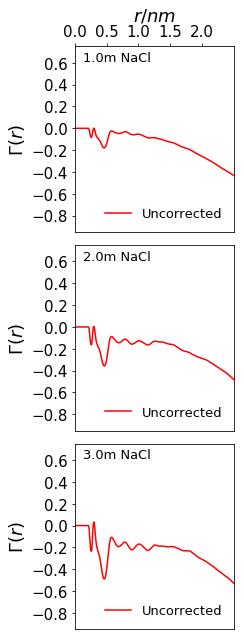

In [5]:
pot = 'qpotential'

cutoff_value = 1.28

moments = 2

cations = ['Na']

anions = ['Cl']
anion = anions[0]
rdfAtom = 'Cl'

concs = np.linspace(start=1.0, stop=3.0, num=3)

n_rows = len(concs)
n_cols = len(cations)


fig_dim = np.array((3.5, 9))
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        plotExcCoordNbrs(pot,cutoff_value,moments,cations[j],anion,rdfAtom,concs[i],ax)
        ax.annotate(str(concs[i])+'m '+cations[j]+anion,xy=(.05,.92), fontsize=13, xycoords='axes fraction')
        
        if j == 0:
            ax.yaxis.tick_left()
            ax.yaxis.set_label_position("left")
        
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            
        elif 0<i<5:
            ax.xaxis.set_visible(False)
        
        else:
            ax.xaxis.tick_bottom()
        
        plt.xlim((0, 2.5))
        plt.ylim((-0.95, 0.75))
        plt.xticks(np.arange(0,2.5,0.5), fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc=4, fontsize=13, frameon=False)
        plt.tight_layout(w_pad=0,h_pad=0.6)
plt.show()

## Corrected excess coordination numbers
Here, we add a correction factor to account for the issue asociated with the finite size of simulated systems.

In [6]:
def plotExcCoordNbrsCorrected(pot,cutoff_value,moments,cation,anion,rdfAtom,conc,corrIndex,subplot):
    
    """ This function computes and plots the corrected excess coordination numbers and takes ten arguments:
    - pot: 'PME', 'qpotential', 'SP1', or 'SP3'
    - cutoff_value: 1.28 (nm)
    - moments: 2, 3, 5, 7, or 300
    - cation: 'K' or 'Na'
    - anion: I' or 'Cl'
    - rdfAtom: I' or 'Cl
    - conc - 1.0, 2.0, 3.0 (m)
    - corrIndex - i.e. correction factor: 'Ganguly' or 'Milzetti'
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = '..'

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)

    index = 0 # Initializing concentration index                     
    
    if pot is 'qpotential':
        wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/m'+str(moments)+'/'+cation.lower()+anion.lower()+'/'
    
    else:
        wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/'+cation.lower()+anion.lower()+'/'
    
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'
    
    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    V_avg = 0
    rho_c_avg = 0
    rho_w_avg = 0

    for block in block_range: # Looping over blocks  

        # if pickle file exists, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            V = np.loadtxt(wdir_sim_data+'V_'+str(block))
            V_avg = V_avg + V/len(block_range) # Calculating average among blocks
            rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
            rho_c_avg = rho_c_avg + rho_c/len(block_range)
            
        # if simulation output files exist, use those
        elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):
            
            cnt = 0 # Initializing index to make trajectory only to be read once

            # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
            while (cnt < 1):
                
                import mdtraj as md
                
                struct = md.load_pdb(wdir_sim_data+'out.pdb')
                N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                
                sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom)
   
                print("Reading in trajectory...")
                traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                nbrFrames = traj.n_frames
                start = nbrFrames/10
                traj_equil = traj[start:nbrFrames]
                print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)
                
                cnt = cnt + 1
            
            startFrac = start / nbrFrames

            end = nbrFrames - start
            first = start + (block-1)*end/len(block_range)
            last = start + block*end/len(block_range)

            traj_block = traj[first:last]
            print("Number of frames in trajectory block: ", traj_block.n_frames)

            # Analysis: Calculating RDFs
            r_max = 2.80
            
            pair_cc = traj_block.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
            pair_wc = traj_block.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
            r, g_cc = md.compute_rdf(traj_block, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            r, g_wc = md.compute_rdf(traj_block, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
            g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Average ion-ion rdf
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Average water-ion rdf
            
            # Computing volume using box vectors
            V = 0
            for vec in traj_block.unitcell_lengths:
                V = V + vec[0]*vec[1]*vec[2] / traj_block.n_frames # Volume for current block

            V_avg = V_avg + V/len(block_range) # Average volume (nm³)

            # Computing number density of ions
            rho_c = N_c / V # Number density of ions for current block (nm⁻³)
            rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of ions (nm⁻³)
            
            for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)], [g_cc, g_wc, r, V, rho_c]):

                if file_name in (wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)):
                    f = open( file_name, 'w' )
                    f.write( repr(var) + '\n' )
                    f.close()
                    print("pickle", file_name, "created")
                else: 
                    np.savetxt(file_name, var)
                    print("pickle", file_name, "created")
        
        
        
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
        
        
    # In this step, the coordination numbers using the two different correction factors are calculated

    # Getting increment in array with radii 
    dr = r[1]-r[0]

    # Defining the truncation distance 
    truncInd = 100
    R = r[truncInd] # Equals 1.0 nm

    # Calculating remaining volume as a function of the radius
    Vn = 4*pi/3*r**3 / V_avg

    # Calculating the total number of ions in the box 
    N_c = rho_c_avg*V_avg

    # Calculating coordination number without correction factor
    N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
    N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
    Gamma = N_cc - N_wc

    # Calculating Ganguly correction factors, corresponding rdf:s and coordination numbers, full trajectory
    if corrIndex is 'Ganguly':
        corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
        corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
        g_cc_avg = g_cc_avg * corr_cc
        g_wc_avg = g_wc_avg * corr_wc
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        plotColor = 'green' 

    # Calculating coordination numbers with Krüger correction factor, full trajectory
    elif corrIndex is 'Milzetti':
        corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
        corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
        g_cc_avg = g_cc_avg * corr_cc
        g_wc_avg = g_wc_avg * corr_wc
        N_cc = np.empty(0); N_wc = np.empty(0)
        for i in range(r.size):
            N_cc = np.append( N_cc, rho_c_avg*4*pi * np.sum( (g_cc_avg[:i]-1) * r[:i]**2 * (1-(r[:i]/r[i])**3) * dr ) )
            N_wc = np.append( N_wc, rho_c_avg*4*pi * np.sum( (g_wc_avg[:i]-1) * r[:i]**2 * (1-(r[:i]/r[i])**3) * dr ) )
        #N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
        #N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
        plotColor = 'blue'

    # Calculating gamma function
    Gamma = N_cc - N_wc

    subplot.plot(r,Gamma,color=plotColor,label='Corrected ('+corrIndex+')')
    subplot.set_xlabel("$r/nm$", fontsize=18)
    subplot.set_ylabel("$\Gamma(r)$", fontsize=18)

## Plotting $\Gamma$ based on scaled RDFs

Here, we plot the function $\Gamma$ for the selected forcefield, watermodel and ion pairs, with and without any correction factor applied.

Na Cl 1.0 m
Na Cl 2.0 m
Na Cl 3.0 m


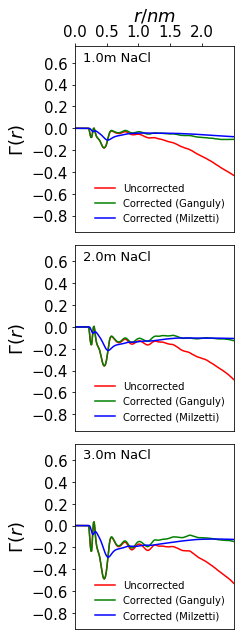

In [7]:
pots = ['PME','qpotential','fanourgakis']

pot = pots[1]

cutoff_value = 1.28

moments = ['None', 2, 3, 4, 6]

moment = moments[1]

cations = ['Na']

anions = ['Cl']
anion = anions[0]

rdfAtom = 'Cl'

concs = np.linspace(start=1.0, stop=3.0, num=3)

n_rows = len(concs)
n_cols = len(cations)


fig_dim = np.array((3.5, 9))
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
            
        print(cations[j],anion,concs[i],'m')
        
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        plotExcCoordNbrs(pot,cutoff_value,moment,cations[j],anion,rdfAtom,concs[i],ax)
        plotExcCoordNbrsCorrected(pot,cutoff_value,moment,cations[j],anion,rdfAtom,concs[i],'Ganguly',ax)
        plotExcCoordNbrsCorrected(pot,cutoff_value,moment,cations[j],anion,rdfAtom,concs[i],'Milzetti',ax)

        ax.annotate(str(concs[i])+'m '+cations[j]+anion,xy=(.05,.92), fontsize=13, xycoords='axes fraction')
        
        if j == 0:
            ax.yaxis.tick_left()
            ax.yaxis.set_label_position("left")
        
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            
        elif 0<i<5:
            ax.xaxis.set_visible(False)
        
        else:
            ax.xaxis.tick_bottom()
        
        
        plt.xlim((0, 2.5))
        plt.ylim((-0.95, 0.75))
        plt.xticks(np.arange(0,2.5,0.5), fontsize=15)
        plt.yticks(fontsize=15)
        
        plt.legend(loc=4, fontsize=10, frameon=False)
            
        plt.tight_layout(w_pad=0,h_pad=0.6)
plt.show()

## Calculating the wanted property,  $a_{c}'$

In the next two cells, we calculate and plot the activity derivative, $a_{c}'$, based on the corrected excess coordination numbers. The property is defined as
\begin{align}
a_{c}' = \left (\frac{\partial \ln a_c}{\partial \ln \rho_c}\right )_{p,T}=\frac{1}{1+\Delta N_{cc}-\Delta N_{wc}}
\end{align}

In [8]:
def actDer(pot,cutoff_value,moments,cation,anion,rdfAtom,approach,subplot, I):
    
    """ This function plots activity derivatives and takes ten arguments:
    - pot: 'PME', 'qpotential', 'SP1', or 'SP3' 
    - cutoff_value: 1.28 (nm)
    - moments: 2, 3, 5, 7, or 300
    - cation: 'Na'
    - anion: 'I' or 'Cl'
    - rdfAtom: 'I' or 'Cl'
    - approach: 'CR' or 'LR'
    - subplot (i.e. where the subplot will appear)
    """
    
    #print(cutoff_value)
    WORKDIR = '..'
    
    # Defining molar mass of water (kg/mol)
    MW_H2O = 18.01528e-3
    
    # Listing avalable molal concentrations (mol/(kg solvent))
    concs_m = np.linspace(start=1.0, stop=3.0, num=3) 

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)

    # Declaring variables that will be calculated later
    molar = np.empty([1, len(concs_m)]) # molar concentrations [mol/l]
    molal = np.empty([1, len(concs_m)]) # molal concentrations [mol/(kg solvent)]
    actDer = np.empty([len(block_range),len(concs_m)]) # activity derivatives per block
    actDerErr = np.empty([2, len(concs_m)]) # standard deviation among blocks
    actDerAvg = np.empty([1,len(concs_m)]) # activity derivative, full trajectory
    
    index = 0 # Initializing concentration index
    
    cr_upper = 1.1 if anion=='SCN' else .9
    cr_lower = .8 if anion=='SCN' else .7
    if cation=='K' and anion != 'SCN': 
        cr_lower = cr_lower + .05
        cr_upper = cr_upper + .05
    
    for conc_m in concs_m: # Looping over concentrations                      
        
        #print("Concentration =", conc_m, " m")
    
        if pot is 'qpotential':
            wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/m'+str(moments)+'/'+cation.lower()+anion.lower()+'/'
        
        else:
            wdir_exp_data = WORKDIR+'/data/'+pot+'/'+str(cutoff_value)+'nm/'+cation.lower()+anion.lower()+'/'
        
        wdir_sim_data = wdir_exp_data+str(conc_m)+'m/'
        print(wdir_sim_data)
        ind = 0 # Initializing block index
        
        cnt = 0 # Initializing index to make trajectory only to be read once
        
        g_cc_avg = 0 # Initializing radial distribution function of ion around ion
        g_wc_avg = 0 # Initializing radial distribution function of ion around water
        V_avg = 0 # Initializing volume of the system
        rho_c_avg = 0 # Initializing salt density of system    
        rho_w_avg = 0 # Initializing water density of system    
        
        for block in block_range: # Looping over blocks  
            
            # if pickle file exists, use that
            if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_w_'+str(block) ):        

                # print("Loading from saved pickle")

                # Loading stored files from directory
                g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
                g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
                g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
                g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
                r = np.loadtxt(wdir_sim_data+'r_'+str(block))
                V = np.loadtxt(wdir_sim_data+'V_'+str(block))
                V_avg = V_avg + V/len(block_range) # Calculating average among blocks
                rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
                rho_c_avg = rho_c_avg + rho_c/len(block_range)
                rho_w = np.loadtxt(wdir_sim_data+'rho_w_'+str(block))
                rho_w_avg = rho_w_avg + rho_w/len(block_range)

            # if simulation output files exist, use those
            elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):
                                
                # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
                while (cnt < 1):
                    
                    import mdtraj as md
                    
                    struct = md.load_pdb(wdir_sim_data+'out.pdb')
                    
                    print("Loading following structure file: ", wdir_sim_data+'out.pdb')
                    
                    N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                    N_w = len(struct.topology.select('name O')) # Number of water molecules
                    
                    print('Number of ions in block '+str(block)+':', N_c)
                    print('Number of water molecules in block '+str(block)+':', N_w)
                    
                    sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom)

                    print("Reading in trajectory...")
                    traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                    nbrFrames = traj.n_frames
                    start = nbrFrames/10
                    traj_equil = traj[start:nbrFrames]
                    print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)
                    
                    cnt = cnt + 1

                startFrac = start / nbrFrames

                end = nbrFrames - start
                first = start + (block-1)*end/len(block_range)
                last = start + block*end/len(block_range)

                traj_block = traj[first:last]
                print("Number of frames in trajectory block: ", traj_block.n_frames)

                # Analysis: Calculating RDFs
                r_max = 2.80

                pair_cc = traj_block.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
                pair_wc = traj_block.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
                r, g_cc = md.compute_rdf(traj_block, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
                r, g_wc = md.compute_rdf(traj_block, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
                corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
                g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

                g_cc_avg = g_cc_avg+g_cc/len(block_range) # Average ion-ion rdf
                g_wc_avg = g_wc_avg+g_wc/len(block_range) # Average water-ion rdf

                # Computing volume using box vectors
                V = 0
                for vec in traj_block.unitcell_lengths:
                    V = V + vec[0]*vec[1]*vec[2] / traj_block.n_frames # Volume for current block

                V_avg = V_avg + V/len(block_range) # Average volume (nm³)

                # Computing number density of ions
                rho_c = N_c / V # Number density of ions in current block (nm⁻³)
                rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of ions (nm⁻³)
                
                # Computing number density of water
                rho_w = N_w / V # Number density of water in current block (nm⁻³)
                rho_w_avg = rho_w_avg + rho_w/len(block_range) # Average number density of water (nm⁻³)
                
                for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block), wdir_sim_data+'rho_w_'+str(block)], [g_cc, g_wc, r, V, rho_c, rho_w]):

                    if file_name in (wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block), wdir_sim_data+'rho_w_'+str(block)):
                        f = open( file_name, 'w' )
                        f.write( repr(var) + '\n' )
                        f.close()
                        print("pickle", file_name, "created")
                    else: 
                        np.savetxt(file_name, var)
                        print("pickle", file_name, "created")

            else:
                print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")

            # In this step, the coordination numbers using the two different correction factors are calculated
            
            # Defining the truncation distance 
            truncInd = 100
            R = r[truncInd] # Equals 1.0 nm

            # Getting increment in array with radii 
            dr = r[1]-r[0]

            # Calculating coordination number without correction factor
            N_cc = rho_c * 4 * pi * np.cumsum( ( g_cc - 1 ) * r ** 2 * dr )
            N_wc = rho_c * 4 * pi * np.cumsum( ( g_wc - 1 ) * r ** 2 * dr )
            Gamma = N_cc - N_wc

            # Calculating remaining volume as a function of the radius
            Vn = 4*pi/3*r**3 / V

            N_c = rho_c*V
            N_w = rho_w*V    
            
            #print("Number of ions: ", N_c)
            #print("Number of water molecules: ", N_w)
            
            # Averaging in the correlated regime (CR method DOI: 10.1021/acs.jpcb.7b11831)
            if approach is 'CR':
                Gamma_plateau = Gamma[(r>=cr_lower)*(r<=cr_upper)].mean() # averaging window 0.9–1.3
            # Long Range Approach by Milzetti et al. DOI: 10.1021/acs.jpcb.7b11831 
            elif approach is 'LR':
                # correction by Ganguly and van der Vegt DOI: 10.1021/ct301017q
                #Vn = 4*pi/3*r**3 / V[-1]; N_c = rho_c[-1]*V[-1]; N_w = rho_w[-1]*V[-1]
                corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
                corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
                g_ccc = g_cc * corr_cc
                g_wcc = g_wc * corr_wc
                # correction by Krüger et al. DOI: 10.1021/jz301992u
                N_ccc = np.empty(0); N_wcc = np.empty(0)
                for i in range(r.size):
                    N_ccc = np.append(N_ccc,rho_c*4*pi*np.sum((g_ccc[:i]-1)*r[:i]**2*(1-(r[:i]/r[i])**3)*dr) )
                    N_wcc = np.append(N_wcc,rho_c*4*pi*np.sum((g_wcc[:i]-1)*r[:i]**2*(1-(r[:i]/r[i])**3)*dr) )
                #N_ccc = rho_c * 4 * pi * np.cumsum( ( g_ccc - 1 ) * r ** 2 * dr )
                #N_wcc = rho_c * 4 * pi * np.cumsum( ( g_wcc - 1 ) * r ** 2 * dr )
                Gamma = N_ccc - N_wcc 
                Gamma_plateau = np.mean(Gamma[100])
                #Gamma_plateau = Gamma[(r>=1.6)*(r<=1.8)].mean() # averaging window 1.8–2.2
            
            # Calculating activity derivative for the current block and concentration
            actDer[ind, index] = 1 / ( 1 + Gamma_plateau )

            # Increasing block index with 1
            ind = ind + 1

        # Calculating average coordination numbers without correction factor
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        Gamma_avg = N_cc - N_wc
        
        # Calculating average, remaining volume as a function of the radius
        Vn = 4*pi/3*r**3 / V_avg

        N_c = rho_c_avg*V_avg
        N_w = rho_w_avg*V_avg   
        
        # Averaging in the correlated regime (CR method DOI: 10.1021/acs.jpcb.7b11831)
        if approach is 'CR':
            Gamma_plateau_avg = Gamma_avg[(r>=cr_lower)*(r<=cr_upper)].mean()
        # Long Range Approach by Milzetti et al. DOI: 10.1021/acs.jpcb.7b11831
        elif approach is 'LR':
            # correction by Ganguly and van der Vegt DOI: 10.1021/ct301017q
            corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
            corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
            g_ccc = g_cc_avg * corr_cc
            g_wcc = g_wc_avg * corr_wc

            # correction by Krüger et al. DOI: 10.1021/jz301992u
            N_ccc = np.empty(0); N_wcc = np.empty(0)
            for i in range(r.size):
                N_ccc = np.append(N_ccc,rho_c_avg*4*pi*np.sum((g_ccc[:i]-1)*r[:i]**2*(1-(r[:i]/r[i])**3)*dr) )
                N_wcc = np.append(N_wcc,rho_c_avg*4*pi*np.sum((g_wcc[:i]-1)*r[:i]**2*(1-(r[:i]/r[i])**3)*dr) )

            # Calculating gamma function, used to calculate the activity derivative
            Gamma_avg = N_ccc - N_wcc 
            Gamma_plateau_avg = np.mean(Gamma[100])
        
        # Calculate activity derivative
        actDerAvg[0, index] = 1 / ( 1 + Gamma_plateau_avg ) 
         
        # Obtaining the standard deviation among blocks of activity derivatives,
        actDerErr[0, index] = np.std(actDer[:, index]) 
        
        # where one is later plotted upwards from the mean value and the other downwards
        actDerErr[1, index] = np.std(actDer[:, index]) 
        # Obtaining the standard deviation among blocks of activity derivatives
        
        molar[0, index] = N_c/(2*V_avg*1e-24*6.022e23)
        molal[0, index] = N_c/(2*N_w*MW_H2O) # Obtaining molality, based on system quantities
        
        actDerAvg[0, index] = np.mean(actDer[:, index]) 

        # Obtaining the standard deviation among blocks of activity derivatives
        actDerErr[0, index] = np.std(actDer[:, index]) 
        # where one is later plotted upwards from the mean value and the other downwards
        actDerErr[1, index] = np.std(actDer[:, index]) 
                
        index = index + 1 # Increasing concentration index by 1

    # Loading experimental data
    m = np.loadtxt(wdir_exp_data+'molality', delimiter=',', unpack=True)
    a = np.loadtxt(wdir_exp_data+'actDer', delimiter=',', unpack=True)
    mShort = m[0:360]
    aShort = a[0:360]

    # Labelling axes
    subplot.set_xlabel(r'molality, $m$  / mol kg$^{-1}$')
    
    if subplot is ax1:
        subplot.set_ylabel(r'$a_{c}^{\prime}$')

    # Specifying color and symbol to use in the plot, depending on ion pair and correction used
    if anion is 'Cl':
        ionColor = 'black'

    elif anion is 'I':
        ionColor = 'black'
    
    if moments is 'None':
        if pot is 'PME':
            symbol = '*'
            color='black'
            label = 'PME'
        elif pot is 'SP3': 
            if cutoff_value == 1.0:
                symbol = 'p'
            else:
                symbol = '<'
                color=colors[7]
                label = 'SP3'
        elif pot is 'SP1':
            symbol = '>'
            color=colors[6]
            label = 'SP1'
        elif pot is 'polynomial':
            symbol = 'v'
            color=colors[4]
            label = 'polynomial'
        elif pot is 'minimal':
            symbol = '^'
            color=colors[5]
            label = 'minimal'
            
    if pot is 'qpotential':
        label = r'$q(P='+str(moments)+'$)'
        
        if moments is 1:
            symbol = 'h'
            color=colors[1]

        if moments is 2:
            symbol = '8'
            color=colors[1]

        if moments is 3:
            symbol = 'p'
            color=colors[2]
            
        if moments is 4:
            symbol = 'd'
            color=colors[4]
            #color=colors[5]

        if moments is 5:
            symbol = 's'
            color=colors[3]

        if moments is 6:
            symbol = 'D'
            color=colors[5]
            
        if moments is 7:
            symbol = 'v'
            color=colors[4]

        if moments == 300:
            symbol = '^'
            color=colors[5]
            label = r'$q(P=\infty)$'
        
    # Plotting continuous experimental activity derivative curves together with simulated data points
    subplot.plot(mShort, aShort+I*0.3, color=color, lw=1, alpha=0.4)
    subplot.errorbar(molal[0,:], actDerAvg[0,:]+I*0.3, actDerErr[:,:], color=color, marker=symbol, ms=5, lw=0,
            markeredgecolor=color,fillstyle='full', markerfacecolor=color, label=label,mew=0.6, elinewidth=1,capsize=3)
    
    subplot.set_xlim((0, 3.5))
    subplot.set_ylim((0.85, 4.15))
    
    subplot.annotate(cation+anion,xy=(.05,.9), fontsize=fontSizeLegend, xycoords='axes fraction')

## Plotting $a_{c}'$ for NaCl and NaI using different potentials

../data/PME/1.28nm/nacl/1.0m/
../data/PME/1.28nm/nacl/2.0m/
../data/PME/1.28nm/nacl/3.0m/
../data/SP3/1.28nm/nacl/1.0m/
../data/SP3/1.28nm/nacl/2.0m/
../data/SP3/1.28nm/nacl/3.0m/
../data/SP1/1.28nm/nacl/1.0m/
../data/SP1/1.28nm/nacl/2.0m/
../data/SP1/1.28nm/nacl/3.0m/
../data/qpotential/1.28nm/m300/nacl/1.0m/
../data/qpotential/1.28nm/m300/nacl/2.0m/
../data/qpotential/1.28nm/m300/nacl/3.0m/
../data/qpotential/1.28nm/m7/nacl/1.0m/
../data/qpotential/1.28nm/m7/nacl/2.0m/
../data/qpotential/1.28nm/m7/nacl/3.0m/
../data/qpotential/1.28nm/m5/nacl/1.0m/
../data/qpotential/1.28nm/m5/nacl/2.0m/
../data/qpotential/1.28nm/m5/nacl/3.0m/
../data/qpotential/1.28nm/m3/nacl/1.0m/
../data/qpotential/1.28nm/m3/nacl/2.0m/
../data/qpotential/1.28nm/m3/nacl/3.0m/
../data/qpotential/1.28nm/m2/nacl/1.0m/
../data/qpotential/1.28nm/m2/nacl/2.0m/
../data/qpotential/1.28nm/m2/nacl/3.0m/
../data/PME/1.28nm/nai/1.0m/
../data/PME/1.28nm/nai/2.0m/
../data/PME/1.28nm/nai/3.0m/
../data/SP3/1.28nm/nai/1.0m/
../data/

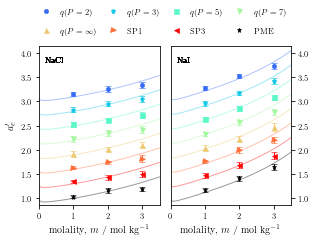

In [9]:
from matplotlib import rc
from matplotlib import container
from matplotlib.font_manager import FontProperties
import gc ; gc.collect()

plt.rcParams.update({'figure.figsize': [4.4302125, 2.913475]})   # [5.2702125, 2.713475]
mpl.rcParams['figure.facecolor'] = '1'


fontSizeLabels=10
fontSizeLegend=8 
fontSizeTicks=8

plt.rcParams.update(
    {
        'font.size': fontSizeLegend,
        'axes.labelsize': fontSizeLabels,
        'xtick.labelsize':fontSizeTicks,
        'ytick.labelsize':fontSizeTicks,
        'legend.fontsize':fontSizeLegend
    }
)
rc('font',**{'family':'serif','sans-serif':['Times New Roman']})
rc('text', usetex=True)

cmap = plt.get_cmap('rainbow')
colors = cmap((np.linspace(0, 1, 8)))
font0 = FontProperties()


f, ((ax1, ax2)) = plt.subplots(1, 2, sharex=False, sharey=False)

pot = ['PME','qpotential', 'SP3', 'SP1']

cutoff = 1.28

moments = ['None',1,2,3,4,5,6,7,300]

# Here, we call the function actDer defined above. Choose which potentials(s), ion pair(s) and correction factor(s) you wish to plot. 

## NaCl
### PME
actDer(pot[0],cutoff,moments[0],'Na','Cl','Cl','LR',ax1,0)

### Fanourgakis
actDer(pot[2],cutoff,moments[0],'Na','Cl','Cl','LR',ax1,1)

### Fennell
actDer(pot[3],cutoff,moments[0],'Na','Cl','Cl','LR',ax1,2)

### q-potential
actDer(pot[1],cutoff,moments[8],'Na','Cl','Cl','LR',ax1,3)
actDer(pot[1],cutoff,moments[7],'Na','Cl','Cl','LR',ax1,4)
actDer(pot[1],cutoff,moments[5],'Na','Cl','Cl','LR',ax1,5)
actDer(pot[1],cutoff,moments[3],'Na','Cl','Cl','LR',ax1,6)
actDer(pot[1],cutoff,moments[2],'Na','Cl','Cl','LR',ax1,7)

## NaI
### PME
actDer(pot[0],cutoff,moments[0],'Na','I','I','LR',ax2,0)

### Fanourgakis (SP3)
actDer(pot[2],cutoff,moments[0],'Na','I','I','LR',ax2,1)

### Fennel (SP1)
actDer(pot[3],cutoff,moments[0],'Na','I','I','LR',ax2,2)

### q-potential
actDer(pot[1],cutoff,moments[8],'Na','I','I','LR',ax2,3)
actDer(pot[1],cutoff,moments[7],'Na','I','I','LR',ax2,4)
actDer(pot[1],cutoff,moments[5],'Na','I','I','LR',ax2,5)
actDer(pot[1],cutoff,moments[3],'Na','I','I','LR',ax2,6)
actDer(pot[1],cutoff,moments[2],'Na','I','I','LR',ax2,7)


ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")    
ax1.xaxis.tick_bottom()
ax1.set_xticks([0,1,2,3])

ax2.yaxis.tick_right()
ax2.xaxis.tick_bottom()
ax2.set_xticks([0,1,2,3])


# Fix so no errorbar appears in legend
handles, labels = ax2.get_legend_handles_labels()
new_handles = []
for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)

order = [7,3,6,2,5,1,4,0]
f.legend([new_handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False, ncol=4, bbox_to_anchor=(0.92, 1.15), labelspacing=1.35, columnspacing=1)

# Save figure
plt.tight_layout(w_pad=.5)
plt.savefig('../figs/actDers.pdf',bbox_inches='tight')

plt.show()

## Storing $g_{cc}(r), g_{wc}(r), \Delta N_{cc}(r), \Delta N_{wc}(r)$ as variables
The above quantities are calculated for the pair-potentials and stored as variables. The purpose is to compare quantities obtained using the pair-potentials with the ones obtained with PME. For instance, $4\pi r^2 \cdot (g_{wc}(r)-1)$ is plotted in the last cell for all studied pair-potentials. 

In [10]:
cmap = plt.get_cmap('rainbow')
colors = cmap((np.linspace(0, 1, 8)))

for pot in ('PME', 'qpotential', 'SP1', 'SP3'):
    
    for corr in ('Milzetti', 'Ganguly', 'None'):
        index = 0
        
        if pot is 'qpotential':
            moms = ('m2', 'm3', 'm5', 'm7', 'm300')

        else:
            moms = ['None']
            wdir_sim_data = '../data/'+str(pot)+'/1.28nm/NaCl/2.0m/'
        
        for moments in moms:
            if pot is 'qpotential':
                wdir_sim_data = '../data/qpotential/1.28nm/'+str(moments)+'/NaCl/2.0m/'
                print(wdir_sim_data)

            block_range = np.arange(1,19,1)

            g_cc_avg = 0
            g_wc_avg = 0
            V_avg = 0
            rho_c_avg = 0

            for block in block_range: # Looping over blocks
                g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
                g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
                g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
                g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
                r = np.loadtxt(wdir_sim_data+'r_'+str(block))
                V = np.loadtxt(wdir_sim_data+'V_'+str(block))
                V_avg = V_avg + V/len(block_range) # Calculating average among blocks
                rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
                rho_c_avg = rho_c_avg + rho_c/len(block_range)

            # Getting increment in array with radii 
            dr = r[1]-r[0]

            # Defining the truncation distance 
            truncInd = 100
            R = r[truncInd] # Equals 1.0 nm

            # Calculating remaining volume as a function of the radius
            Vn = 4*pi/3*r**3 / V_avg

            # Calculating the total number of ions in the box 
            N_c = rho_c_avg*V_avg

            # Calculating coordination number without correction factor
            N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
            N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
            Gamma = N_cc - N_wc

            # Calculating Ganguly correction factors, corresponding rdf:s and coordination numbers, full trajectory
            if corr is 'Ganguly':
                corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
                corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
                g_cc_avg = g_cc_avg * corr_cc
                g_wc_avg = g_wc_avg * corr_wc
                N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
                N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
                plotColor = 'green' 

                # Calculating gamma function using Ganguly correction
                if pot is 'PME':
                    Gamma_G_pme = N_cc - N_wc
                    g_cc_G_pme = g_cc_avg
                    g_wc_G_pme = g_wc_avg
                    print(wdir_sim_data, corr)
                    
                if pot is 'qpotential':
                    if moments is 'm2':
                        Gamma_G_qpot_m2 = N_cc - N_wc
                        g_cc_G_qpot_m2 = g_cc_avg
                        g_wc_G_qpot_m2 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm3':
                        Gamma_G_qpot_m3 = N_cc - N_wc
                        g_cc_G_qpot_m3 = g_cc_avg
                        g_wc_G_qpot_m3 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm5':
                        Gamma_G_qpot_m5 = N_cc - N_wc
                        g_cc_G_qpot_m5 = g_cc_avg
                        g_wc_G_qpot_m5 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm7':
                        Gamma_G_qpot_m7 = N_cc - N_wc
                        g_cc_G_qpot_m7 = g_cc_avg
                        g_wc_G_qpot_m7 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm300':
                        Gamma_G_qpot_m300 = N_cc - N_wc
                        g_cc_G_qpot_m300 = g_cc_avg
                        g_wc_G_qpot_m300 = g_wc_avg
                        print(wdir_sim_data, corr)

                if pot is 'SP1':
                    Gamma_G_sp1 = N_cc - N_wc
                    g_cc_G_sp1 = g_cc_avg
                    g_wc_G_sp1 = g_wc_avg
                    print(wdir_sim_data, corr)

                if pot is 'SP3':
                    Gamma_G_sp3 = N_cc - N_wc
                    g_cc_G_sp3 = g_cc_avg
                    g_wc_G_sp3 = g_wc_avg
                    print(wdir_sim_data, corr)

                    
            # Calculating Milzetti correction factors, corresponding rdf:s and coordination numbers, full trajectory
            elif corr is 'Milzetti':
                corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
                corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
                g_cc_avg = g_cc_avg * corr_cc
                g_wc_avg = g_wc_avg * corr_wc
                N_cc = np.empty(0); N_wc = np.empty(0)
                g_cc_M_Jac = np.empty(0); g_wc_M_Jac = np.empty(0)
                for i in range(r.size):
                    g_cc_M_Jac = np.append( g_cc_M_Jac, (g_cc_avg[i]-1) * 4 * np.pi * r[i]**2 * (1-(r[i]/r[200])**3))
                    g_wc_M_Jac = np.append( g_wc_M_Jac, (g_wc_avg[i]-1) * 4 * np.pi * r[i]**2 * (1-(r[i]/r[200])**3))
                    N_cc = np.append( N_cc, rho_c_avg*4*pi * np.sum( (g_cc_avg[:i]-1) * r[:i]**2 * (1-(r[:i]/r[i])**3) * dr ) )
                    N_wc = np.append( N_wc, rho_c_avg*4*pi * np.sum( (g_wc_avg[:i]-1) * r[:i]**2 * (1-(r[:i]/r[i])**3) * dr ) )
                plotColor = 'blue'
                # Calculating gamma function using Milzetti correction
                if pot is 'PME':
                    Gamma_M_pme = N_cc - N_wc
                    g_cc_M_pme_Jac = g_cc_M_Jac
                    g_wc_M_pme_Jac = g_wc_M_Jac
                    print(wdir_sim_data, corr)

                if pot is 'qpotential':
                    if moments is 'm2':
                        Gamma_M_qpot_m2 = N_cc - N_wc
                        g_cc_M_qpot_m2_Jac = g_cc_M_Jac
                        g_wc_M_qpot_m2_Jac = g_wc_M_Jac
                        print(wdir_sim_data, corr)
                    if moments is 'm3':
                        Gamma_M_qpot_m3 = N_cc - N_wc
                        g_cc_M_qpot_m3_Jac = g_cc_M_Jac
                        g_wc_M_qpot_m3_Jac = g_wc_M_Jac
                        print(wdir_sim_data, corr)
                    if moments is 'm5':
                        Gamma_M_qpot_m5 = N_cc - N_wc
                        g_cc_M_qpot_m5_Jac = g_cc_M_Jac
                        g_wc_M_qpot_m5_Jac = g_wc_M_Jac
                        print(wdir_sim_data, corr)
                    if moments is 'm7':
                        Gamma_M_qpot_m7 = N_cc - N_wc
                        g_cc_M_qpot_m7_Jac = g_cc_M_Jac
                        g_wc_M_qpot_m7_Jac = g_wc_M_Jac
                        print(wdir_sim_data, corr)
                    if moments is 'm300':
                        Gamma_M_qpot_m300 = N_cc - N_wc
                        g_cc_M_qpot_m300_Jac = g_cc_M_Jac
                        g_wc_M_qpot_m300_Jac = g_wc_M_Jac
                        print(wdir_sim_data, corr)

                elif pot is 'SP1':
                    Gamma_M_sp1 = N_cc - N_wc
                    g_cc_M_sp1_Jac = g_cc_M_Jac
                    g_wc_M_sp1_Jac = g_wc_M_Jac
                    print(wdir_sim_data, corr)

                elif pot is 'SP3':
                    Gamma_M_sp3 = N_cc - N_wc
                    g_cc_M_sp3_Jac = g_cc_M_Jac
                    g_wc_M_sp3_Jac = g_wc_M_Jac
                    print(wdir_sim_data, corr)
                    
            elif corr is 'None':
                
                N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
                N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
                # Calculating gamma function using Milzetti correction
                if pot is 'PME':
                    Gamma_pme = N_cc - N_wc
                    g_cc_pme = g_cc_avg
                    g_wc_pme = g_wc_avg
                    print(wdir_sim_data, corr)

                if pot is 'qpotential':
                    if moments is 'm2':
                        Gamma_qpot_m2 = N_cc - N_wc
                        g_cc_qpot_m2 = g_cc_avg
                        g_wc_qpot_m2 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm3':
                        Gamma_qpot_m3 = N_cc - N_wc
                        g_cc_qpot_m3 = g_cc_avg
                        g_wc_qpot_m3 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm5':
                        Gamma_qpot_m5 = N_cc - N_wc
                        g_cc_qpot_m5 = g_cc_avg
                        g_wc_qpot_m5 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm7':
                        Gamma_qpot_m7 = N_cc - N_wc
                        g_cc_qpot_m7 = g_cc_avg
                        g_wc_qpot_m7 = g_wc_avg
                        print(wdir_sim_data, corr)
                    if moments is 'm300':
                        Gamma_qpot_m300 = N_cc - N_wc
                        g_cc_qpot_m300 = g_cc_avg
                        g_wc_qpot_m300 = g_wc_avg
                        print(wdir_sim_data, corr)

                elif pot is 'SP1':
                    Gamma_sp1 = N_cc - N_wc
                    g_cc_sp1 = g_cc_avg
                    g_wc_sp1 = g_wc_avg
                    print(wdir_sim_data, corr)

                elif pot is 'SP3':
                    Gamma_sp3 = N_cc - N_wc
                    g_cc_sp3 = g_cc_avg
                    g_wc_sp3 = g_wc_avg
                    print(wdir_sim_data, corr)

../data/PME/1.28nm/NaCl/2.0m/ Milzetti
../data/PME/1.28nm/NaCl/2.0m/ Ganguly
../data/PME/1.28nm/NaCl/2.0m/ None
../data/qpotential/1.28nm/m2/NaCl/2.0m/
../data/qpotential/1.28nm/m2/NaCl/2.0m/ Milzetti
../data/qpotential/1.28nm/m3/NaCl/2.0m/
../data/qpotential/1.28nm/m3/NaCl/2.0m/ Milzetti
../data/qpotential/1.28nm/m5/NaCl/2.0m/
../data/qpotential/1.28nm/m5/NaCl/2.0m/ Milzetti
../data/qpotential/1.28nm/m7/NaCl/2.0m/
../data/qpotential/1.28nm/m7/NaCl/2.0m/ Milzetti
../data/qpotential/1.28nm/m300/NaCl/2.0m/
../data/qpotential/1.28nm/m300/NaCl/2.0m/ Milzetti
../data/qpotential/1.28nm/m2/NaCl/2.0m/
../data/qpotential/1.28nm/m2/NaCl/2.0m/ Ganguly
../data/qpotential/1.28nm/m3/NaCl/2.0m/
../data/qpotential/1.28nm/m3/NaCl/2.0m/ Ganguly
../data/qpotential/1.28nm/m5/NaCl/2.0m/
../data/qpotential/1.28nm/m5/NaCl/2.0m/ Ganguly
../data/qpotential/1.28nm/m7/NaCl/2.0m/
../data/qpotential/1.28nm/m7/NaCl/2.0m/ Ganguly
../data/qpotential/1.28nm/m300/NaCl/2.0m/
../data/qpotential/1.28nm/m300/NaCl/2.0m/ Gan

## Plotting the function $4\pi r^2 \cdot (g_{wc}(r)-1)$

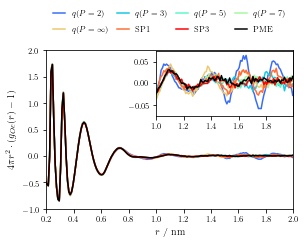

In [11]:
from matplotlib.font_manager import FontProperties
from matplotlib import rc
from matplotlib import container
import gc ; gc.collect()

plt.rcParams.update({'figure.figsize': [4.4302125, 2.913475]})
mpl.rcParams['figure.facecolor'] = '1'

fontSizeLabels=10
fontSizeLegend=8 
fontSizeTicks=8

plt.rcParams.update(
    {
        'font.size': fontSizeLegend,
        'axes.labelsize': fontSizeLabels,
        'xtick.labelsize':fontSizeTicks,
        'ytick.labelsize':fontSizeTicks,
        'legend.fontsize':fontSizeLegend
    }
)
rc('font',**{'family':'serif','sans-serif':['Times New Roman']})
rc('text', usetex=True)

cmap = plt.get_cmap('rainbow')
colors = cmap((np.linspace(0, 1, 8)))
font0 = FontProperties()

fig, ax1 = plt.subplots()
left, bottom, width, height = [0.47, 0.569, 0.43, 0.31]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(r,(g_wc_qpot_m2-1)*4*np.pi*r**2,color=colors[1], label=r'$q(P=2)$')
ax1.plot(r,(g_wc_qpot_m3-1)*4*np.pi*r**2,color=colors[2], label=r'$q(P=3)$')
ax1.plot(r,(g_wc_qpot_m5-1)*4*np.pi*r**2,color=colors[3], label=r'$q(P=5)$')
ax1.plot(r,(g_wc_qpot_m7-1)*4*np.pi*r**2,color=colors[4], label=r'$q(P=7)$')
ax1.plot(r,(g_wc_qpot_m300-1)*4*np.pi*r**2,color=colors[5], label=r'$q(P=\infty)$')
ax1.plot(r,(g_wc_sp1-1)*4*np.pi*r**2,color=colors[6], label='SP1')
ax1.plot(r,(g_wc_sp3-1)*4*np.pi*r**2,color=colors[7], label='SP3')
ax1.plot(r,(g_wc_pme-1)*4*np.pi*r**2,color='black', label='PME')
ax1.set_xlabel(r'$r$ / nm', fontsize=10)
ax1.set_ylabel(r'$4\pi r^2\cdot(g_{Oc}(r)-1)$', fontsize=10)
ax1.set_xlim((0.2, 2.0))
ax1.set_ylim((-1.0, 2.0))
ax1.set_xticks([0.2,0.4,0.6,0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

ax2.plot(r,(g_wc_qpot_m2-1)*4*np.pi*r**2,color=colors[1], label=r'$q(P=2)$')
ax2.plot(r,(g_wc_qpot_m3-1)*4*np.pi*r**2,color=colors[2], label=r'$q(P=3)$')
ax2.plot(r,(g_wc_qpot_m5-1)*4*np.pi*r**2,color=colors[3], label=r'$q(P=5)$')
ax2.plot(r,(g_wc_qpot_m7-1)*4*np.pi*r**2,color=colors[4], label=r'$q(P=7)$')
ax2.plot(r,(g_wc_qpot_m300-1)*4*np.pi*r**2,color=colors[5], label=r'$q(P=\infty)$')
ax2.plot(r,(g_wc_sp1-1)*4*np.pi*r**2,color=colors[6], label='SP1')
ax2.plot(r,(g_wc_sp3-1)*4*np.pi*r**2,color=colors[7], label='SP3')
ax2.plot(r,(g_wc_pme-1)*4*np.pi*r**2,color='black', label='PME')
ax2.set_xlim((1, 2.0))
ax2.set_ylim((-0.075, 0.075))
ax2.set_xticks([1.0, 1.2, 1.4, 1.6,1.8])

order = [0, 4, 1, 5, 2, 6, 3, 7] 
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(1,1.3), frameon=False, labelspacing=1, ncol=4, columnspacing=1.0, handlelength=1.5)

plt.savefig('../figs/g-1xJacobian.pdf',bbox_inches='tight')